MCB with Attention

In [2]:
import mxnet as mx
import numpy as np
out_dim = 6
compute_size = 128
def MCB_unit(data1,data2,out_dim,name,compute_size = 128, ifftflag = True):
#data1 = mx.sym.Variable('data1')
#data2 = mx.sym.Variable('data2')
#for i in range(order)
    cs1 = mx.sym.CountSketch( data = data1,name= name +'_cs1',out_dim = out_dim) 
    cs2 = mx.sym.CountSketch( data = data2,name=name +'_cs2',out_dim = out_dim) 
    fft1 = mx.sym.FFT(data = cs1, name=name+'_fft1', compute_size = compute_size) 
    fft2 = mx.sym.FFT(data = cs2, name=name+'_fft2', compute_size = compute_size) 
    c = fft1 * fft2
    if ifftflag:
        ifft = mx.sym.IFFT(data = c, name=name+'_ifft', compute_size = compute_size) 
        return ifft
    else:
        return c

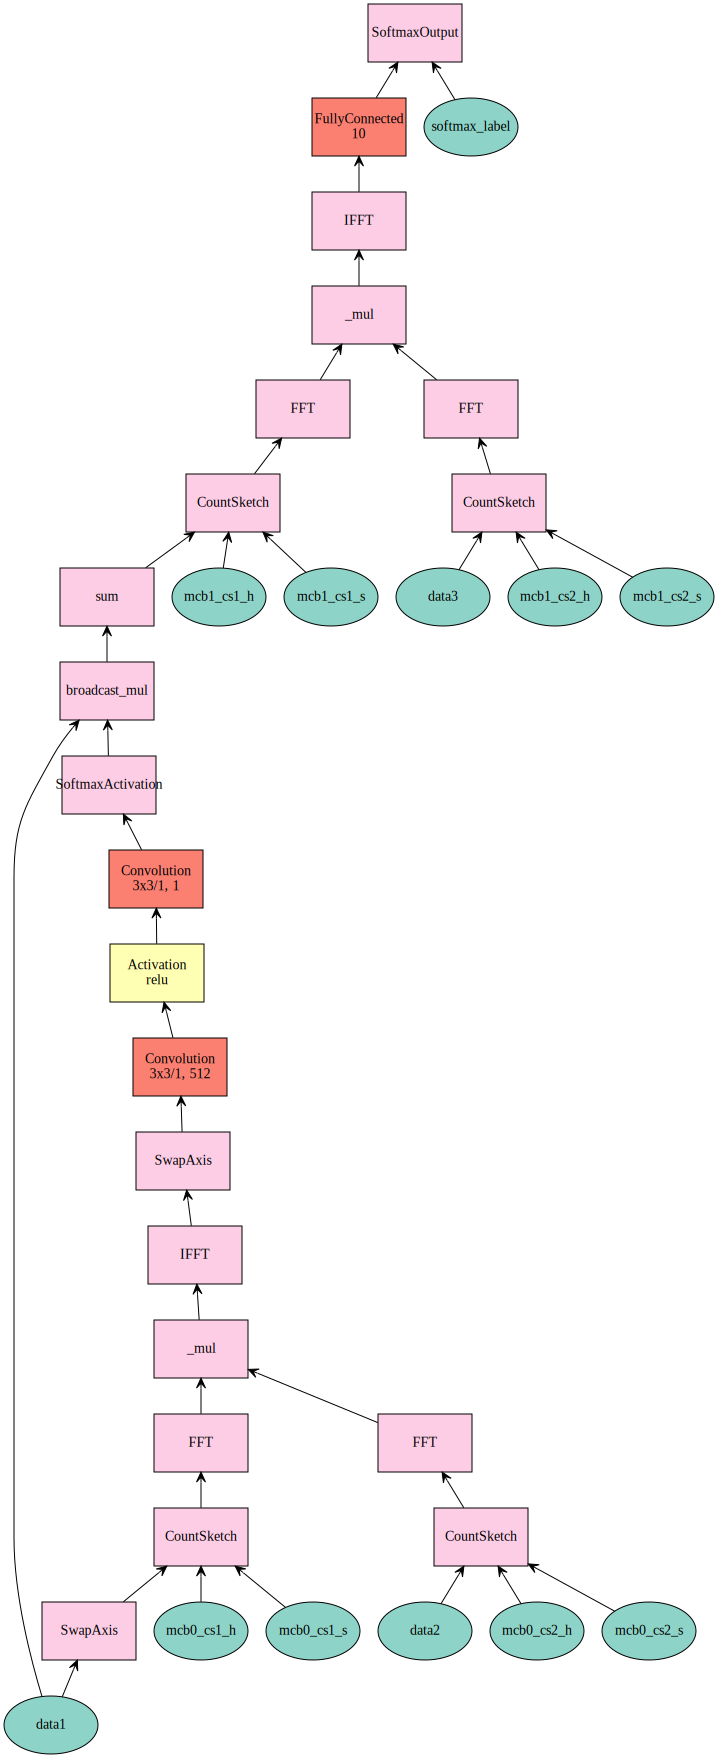

In [3]:
data1 = mx.sym.Variable(name='data1')
data1_swapaxis = mx.sym.SwapAxis(data = data1, dim1 = 1, dim2 = 3)
data2 = mx.sym.Variable(name='data2')
data3 = mx.sym.Variable(name='data3')
ifftflag = True
out_dim = 20
compute_size = 128
workspace = 1024
num_classes = 3000
num_filter = [512,1]

mcb0 = MCB_unit(data1_swapaxis,data2,out_dim,'mcb0',compute_size,ifftflag)
mcb0_swapaxis = mx.sym.SwapAxis(data = mcb0, dim1 = 1, dim2 = 3)
body = mx.sym.Convolution(data=mcb0_swapaxis, num_filter=num_filter[0], kernel=(3, 3), stride=(1,1), pad=(1, 1),
                                  no_bias=True, name="conv0", workspace=workspace)
body = mx.sym.Activation(data=body, act_type='relu', name='relu0')
body = mx.sym.Convolution(data=body, num_filter=num_filter[1], kernel=(3, 3), stride=(1,1), pad=(1, 1),
                                  no_bias=True, name="conv1", workspace=workspace)
body = mx.symbol.SoftmaxActivation(data=body, name='softmax0') 
image_attention = mx.sym.broadcast_mul(data1,body)
image_attention = mx.sym.sum(image_attention,axis = (2,3))
mcb1 = MCB_unit(image_attention,data3,out_dim,'mcb1',compute_size,ifftflag)

fc0 = mx.symbol.FullyConnected(data=mcb1, num_hidden=num_classes, name='fc0')
out = mx.symbol.SoftmaxOutput(data=fc0, name='softmax')
mx.viz.plot_network(out)    

In [4]:
print(out.list_arguments())

['data1', 'mcb0_cs1_h', 'mcb0_cs1_s', 'data2', 'mcb0_cs2_h', 'mcb0_cs2_s', 'conv0_weight', 'conv1_weight', 'mcb1_cs1_h', 'mcb1_cs1_s', 'data3', 'mcb1_cs2_h', 'mcb1_cs2_s', 'fc0_weight', 'fc0_bias', 'softmax_label']


In [7]:
N = 3
H = 5
W = 5
in_dim = 100
ctx_list = {'ctx': mx.gpu(0),'data1':(N,in_dim,H,W),'mcb0_cs1_h':(1,in_dim),'mcb0_cs1_s':(1,in_dim),
                              'data2':(N,H,W,in_dim),'mcb0_cs2_h':(1,in_dim),'mcb0_cs2_s':(1,in_dim), 
                             'data3':(N,in_dim),'mcb1_cs1_h':(1,in_dim),'mcb1_cs1_s':(1,in_dim), 'mcb1_cs2_h':(1,in_dim),'mcb1_cs2_s':(1,in_dim),
                             'type_dict':{'data1':np.float32,'mcb0_cs1_h':np.float32,'mcb0_cs1_s':np.float32,'data2':np.float32,'mcb0_cs2_h':np.float32,'mcb0_cs2_h':np.float32, 'data3':np.float32,'mcb1_cs2_h':np.float32,'mcb1_cs2_h':np.float32,'mcb1_cs1_h':np.float32,'mcb1_cs1_h':np.float32 }}

In [8]:
exe = out.simple_bind(**ctx_list)
args = dict(zip(out.list_arguments(), exe.arg_arrays))
for name in args:
    print(name, args[name].shape, args[name].context)

('mcb1_cs2_h', (1L, 100L), gpu(0))
('fc0_bias', (10L,), gpu(0))
('fc0_weight', (10L, 20L), gpu(0))
('mcb0_cs1_h', (1L, 100L), gpu(0))
('mcb0_cs2_h', (1L, 100L), gpu(0))
('data1', (3L, 100L, 5L, 5L), gpu(0))
('softmax_label', (3L,), gpu(0))
('mcb1_cs1_h', (1L, 100L), gpu(0))
('mcb0_cs2_s', (1L, 100L), gpu(0))
('data3', (3L, 100L), gpu(0))
('mcb1_cs1_s', (1L, 100L), gpu(0))
('mcb1_cs2_s', (1L, 100L), gpu(0))
('mcb0_cs1_s', (1L, 100L), gpu(0))
('conv0_weight', (512L, 20L, 3L, 3L), gpu(0))
('conv1_weight', (1L, 512L, 3L, 3L), gpu(0))
('data2', (3L, 5L, 5L, 100L), gpu(0))


In [ ]:
for name in args:
    data = args[name]
    if 'weight' in name:
        data[:] = mx.random.uniform(-0.1, 0.1, data.shape)
    if 'bias' in name:
        data[:] = 0
    if 'data' in name:
        data[:] = mx.random.uniform(-10, 10, data.shape)
    if 'h' in name:
        temp = np.random.randint(0, out_dim, data.shape)
        data[:] = mx.nd.array(temp)
    if '_s' in name:
        temp = np.random.randint(0, 2, data.shape)*2-np.ones(data.shape)
        data[:] = mx.nd.array(temp)
    if '_label' in name:
        